In [1]:

%load_ext autoreload
%autoreload 2
import sys
import os
import random
from operator import itemgetter

import numpy as np
import pandas as pd
import awkward as ak
import scipy
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId
from hists.dataframe import DataframeComputations
from event_visualizer.event_index import EventLoader
from event_visualizer.notebook_visualizer import EventDisplay
from ntupleReaders.computation import BaseComputation, computeAllFromTree


from selections import *
from plot import *

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v40'
#clueParams = "single-file"
clueParams = "cmssw"
datatype = "data"

In [3]:
clueClustersFile = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root")
tree = uproot.open(clueClustersFile + ":clusters")
eventLoader = EventLoader(clueClustersFile)

In [4]:
def computeEnergyPerLayerDf(comp:DataframeComputations):
    energySumPerLayer_df = (comp
        .rechits_totalReconstructedEnergyPerEventLayer_allLayers(joinWithBeamEnergy=False)
        .set_index("rechits_layer", append=True)
    )
    energySumPerLayer_df = energySumPerLayer_df.join(energySumPerLayer_df
                .groupby(by="eventInternal")
                .agg(
                    rechits_energy_sum=pd.NamedAgg(column="rechits_energy_sum_perLayer", aggfunc="sum"),
                ))
    return energySumPerLayer_df

In [184]:
def find_peaks(df:pd.DataFrame, settings:dict):
    def apply_fct(grouped_series:pd.Series):
        peaks, properties = scipy.signal.find_peaks(grouped_series, **settings)
        if len(peaks) < 2:
            return None
        else:
            return peaks, properties
    return df.rechits_energy_sum_perLayer.groupby("eventInternal").apply(apply_fct).dropna().rename("peaks_info")

def find_peaks_reverse(df:pd.DataFrame, settings:dict):
    def apply_fct(grouped_series:pd.Series):
        peaks, properties = scipy.signal.find_peaks(-grouped_series, **settings)
        if len(peaks) == 0:
            return None
        else:
            return peaks, properties
    return df.rechits_energy_sum_perLayer.groupby("eventInternal").apply(apply_fct).dropna().rename("peaks_info")

In [185]:
class MakePeaksDfComputation(BaseComputation):
    neededBranches = ["beamEnergy", "event", "ntupleNumber", "rechits_energy", "rechits_layer"]
    def __init__(self, settings, peakFindingFunction) -> None:
        self.dfList = []
        self.perLayerDfList = []
        self.settings = settings
        self.peakFindingFunction = peakFindingFunction

    def process(self, array: ak.Array) -> None:
        comp = DataframeComputations(array, rechits_columns=["rechits_energy", "rechits_layer"])
        energyPerLayer_df = computeEnergyPerLayerDf(comp)
        peaks_series = self.peakFindingFunction(energyPerLayer_df, self.settings)
        
        self.dfList.append(pd.merge(peaks_series, comp.ntupleEvent, how="left", left_index=True, right_index=True))
        
        # Keep only events in energyPerLayer_df that got saved in peaks_series
        energyPerLayer_df = energyPerLayer_df.reset_index("rechits_layer")
        self.perLayerDfList.append(energyPerLayer_df[energyPerLayer_df.index.isin(peaks_series.index)])
    
    def getResult(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        # Use concat with keys= so we can differentiate event nb from different batches
        keys = list(range(len(self.dfList)))
        # the reset_index will create a unique index over all batches
        concatDf = pd.concat(self.dfList, keys=keys).reset_index(names=["batchNumber", "eventInBatch"]).rename_axis(index="eventInternal")
        perLayer_concat = pd.concat(self.perLayerDfList, keys=keys)

        # Now join to the per layer df so we map [batchNumber, eventInBatch] to the unique index in concat_df
        perLayer_indexed = concatDf[["batchNumber", "eventInBatch"]].join(perLayer_concat, on=["batchNumber", "eventInBatch"]).set_index("rechits_layer", append=True)
        return concatDf.drop(columns=["batchNumber", "eventInBatch"]), perLayer_indexed.drop(columns=["batchNumber", "eventInBatch"])

In [186]:
settings=dict(distance=3, prominence=0.5, width=2)
settings_reverse = dict(distance=5,  width=1.5)

In [187]:
peaksDf_comp = MakePeaksDfComputation(settings, find_peaks)
peaksDf_reverse_comp = MakePeaksDfComputation(settings_reverse, find_peaks_reverse)
computeAllFromTree(tree, [peaksDf_reverse_comp])

100%|██████████| 272855/272855 [01:53<00:00, 2410.88it/s]


In [188]:
peaks_df, energyPerLayer_df = MakePeaksDfComputation.getResult(peaksDf_reverse_comp)#peaksDf_reverse_comp.getResult()

In [138]:
peaks_df.iloc[0].peaks_info

(array([ 6, 24]),
 {'prominences': array([1.2383194 , 0.39502338]),
  'left_bases': array([5, 5]),
  'right_bases': array([ 8, 26]),
  'widths': array([1.71284229, 2.137548  ]),
  'width_heights': array([-28.58903885,  -0.4849544 ]),
  'left_ips': array([ 5.76495403, 23.27515795]),
  'right_ips': array([ 7.47779631, 25.41270595])})

In [189]:
energyPerLayer_df#.peaks_info.iloc[0]

rechits_energy_sum_perLayer  rechits_energy_sum
eventInternal rechits_layer                                                 
0             1                                 0.509426          290.045624
              2                                 0.808418          290.045624
              3                                 2.508313          290.045624
              4                                 4.660941          290.045624
              5                                10.185954          290.045624
...                                                  ...                 ...
90573         24                                0.407350          204.503860
              25                                0.223376          204.503860
              26                                0.222028          204.503860
              27                                0.284157          204.503860
              28                                0.011320          204.503860

[2536072 rows x 2 columns]

In [282]:
def filterLowestBaseHeight(df_peaks, df_energyPerLayer, fraction):
    """ Remove peaks where the energy of the lowest peak is less than fraction times the maximum layer energy """
    df = df_peaks.join(energyPerLayer_df.rechits_energy_sum_perLayer.groupby("eventInternal").max().rename("rechits_energy_maxLayer"))
    
    def getEnergyAtLayer(evtInternal, layer):
        return df_energyPerLayer.loc[(evtInternal, layer), "rechits_energy_sum_perLayer"]
    
    def applyFct(row_series):
        peaks, properties = row_series.peaks_info
        evtInternal = row_series.name
        peaks_indices_selection = []
        for peak, left_base, right_base in zip(peaks, properties["left_bases"], properties["right_bases"]):
            # map 0-based to 1-based
            energyAtLowestBase = min(getEnergyAtLayer(evtInternal, left_base+1), getEnergyAtLayer(evtInternal, right_base+1))
            peaks_indices_selection.append(energyAtLowestBase > fraction * row_series.rechits_energy_maxLayer)
        
        if not np.any(peaks_indices_selection):
            return None

        getter = itemgetter(peaks_indices_selection)
        return getter(peaks), {key : getter(val) for key, val in properties.items()}
    
    return df.apply(applyFct, axis="columns").dropna().rename("peaks_info")

def filterIsolatedPeaks(df_peaks, df_energyPerLayer):
    """ Filter out dips which are bordered by an abnormal peak (for example a noisy cell) 
    In case : - the dip min is one layer out from one of the maximas
    - the energy in the dip min is greater than than the layer after the adjacent maxima
    then we drop the dip
    """
    def getEnergyAtLayer(evtInternal, layer):
        try:
            return df_energyPerLayer.loc[(evtInternal, layer), "rechits_energy_sum_perLayer"]
        except Exception:
            return 0
    
    def applyFct(row_series):
        peaks, properties = row_series.peaks_info
        evtInternal = row_series.name
        indices = []
        for peak, left_base, right_base in zip(peaks, properties["left_bases"], properties["right_bases"]):
            if peak == right_base - 1 and getEnergyAtLayer(evtInternal, (peak+1)) > getEnergyAtLayer(evtInternal, (peak+1)+2):
                indices.append(False)
            elif peak == left_base + 1 and getEnergyAtLayer(evtInternal, (peak+1)) > getEnergyAtLayer(evtInternal, (peak+1)-2):
                indices.append(False)
            else:
                indices.append(True)
        
        if not np.any(indices):
            return None

        getter = itemgetter(indices)
        return getter(peaks), {key : getter(val) for key, val in properties.items()}
    return df_peaks.apply(applyFct, axis="columns").dropna()

def filterMostProminentPeak(peaks_info_series:pd.Series):
    def applyFct(peaks_info):
        peaks, properties = peaks_info
        index = np.argmax(properties["prominences"])
        return pd.Series([peaks[index]] + [l[index] for l in properties.values()], index=["peak_index"]+list(properties.keys()))
    return peaks_info_series.apply(applyFct)

In [283]:
filtered_peaks = filterLowestBaseHeight(peaks_df, energyPerLayer_df, 0.5).to_frame().pipe(filterIsolatedPeaks, energyPerLayer_df)

In [284]:
filtered_peaks_joined = peaks_df.drop(columns="peaks_info").join(filterMostProminentPeak(filtered_peaks), how="right")

In [285]:
filtered_peaks_joined#.query("ntupleNumber==665 and event==733")

,ntupleNumber,event,beamEnergy,peak_index,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips
eventInternal,,,,,,,,,,,
2,435,1693,300.0,7.0,0.499941,5.0,8.0,1.509262,-21.451215,5.527344,7.036606
13,435,6077,300.0,11.0,2.076964,8.0,14.0,2.759286,-12.204225,8.662694,11.421980
28,435,3525,300.0,10.0,3.564808,8.0,12.0,2.677146,-18.883028,8.512582,11.189728
48,435,7041,300.0,9.0,4.764729,8.0,12.0,2.887636,-20.468546,8.500000,11.387636
56,435,7399,300.0,10.0,1.729931,8.0,12.0,2.321921,-19.017891,8.971146,11.293067
...,...,...,...,...,...,...,...,...,...,...,...
90383,675,5238,200.0,7.0,0.599672,5.0,8.0,1.527446,-15.217258,5.555763,7.083209
90389,675,7456,200.0,13.0,5.970951,6.0,18.0,3.853736,-7.841818,12.257907,16.111643
90409,675,9412,200.0,9.0,6.267335,8.0,12.0,2.615216,-13.464847,8.500000,11.115216


In [197]:
def plotEvt(evtInternal, peaks_param):
    print(evtInternal)
    try:
        peaksInfo = peaks_param.peaks_info.loc[evtInternal]
    except:
        # Make a peaksInfo object with a single peak
        peaksInfo = np.array([peaks_param.peak_index.loc[evtInternal]]), {key : np.array([peaks_param[key].loc[evtInternal]]) for key in ["prominences","left_bases","right_bases","widths","width_heights","left_ips","right_ips"]}
    plotIndividualProfile_scipy(energyPerLayer_df.rechits_energy_sum_perLayer.loc[evtInternal], *peaksInfo)
    try:
        #hep.cms.label("Preliminary")
        hep.cms.lumitext(f"{peaks_param.beamEnergy.loc[evtInternal]} GeV - ntuple {peaks_param.ntupleNumber.loc[evtInternal]} - event {peaks_param.event.loc[evtInternal]}")
    except:
        pass
    return peaks_df.loc[evtInternal, "peaks_info"]
def plotRandomEvent(peaks_param):
    return plotEvt(random.choice(peaks_param.index), peaks_param)

89414


(array([15]),
 {'prominences': array([3.84629774]),
  'left_bases': array([8]),
  'right_bases': array([20]),
  'widths': array([5.59866098]),
  'width_heights': array([-8.49471402]),
  'left_ips': array([11.96632131]),
  'right_ips': array([17.56498229])})

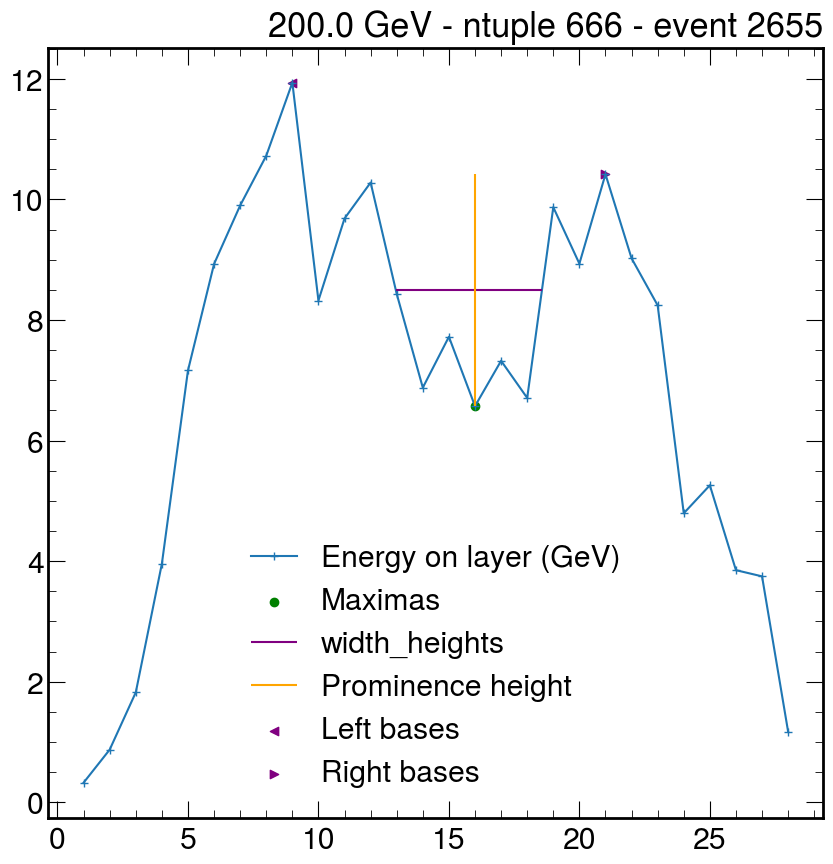

In [245]:
plotEvt(89414, filtered_peaks_joined)

90190


(array([10]),
 {'prominences': array([5.2179141]),
  'left_bases': array([5]),
  'right_bases': array([15]),
  'widths': array([3.56088824]),
  'width_heights': array([-8.39668965]),
  'left_ips': array([7.86555745]),
  'right_ips': array([11.42644569])})

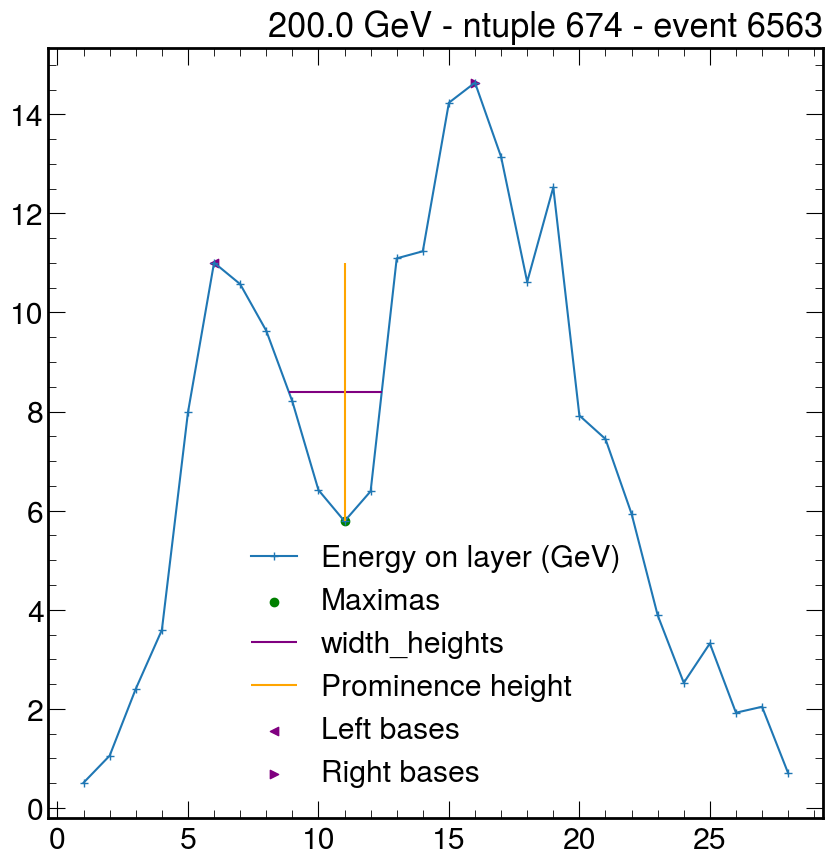

In [308]:
plotRandomEvent(filtered_peaks_joined.query("beamEnergy == 200 and prominences > 5 and widths > 2"))

In [ ]:
peak == right_base - 1 and getEnergyAtLayer(evtInternal, peak+1) > getEnergyAtLayer(evtInternal, peak+2):

In [ ]:
def wrap(f):
    def unpack(tuple_obj):
        return f(*tuple_obj)
    return unpack

In [328]:
from hists.custom_hists import beamEnergiesAxis
h = hist.Hist(beamEnergiesAxis(), hist.axis.Regular(20, 0, 8, name="dipLengthMedian", label="Length of dip, at median height (in layers)"), 
              hist.axis.Regular(30, 0., 6., name="dipProminence", label="Dip prominence (GeV)"))
h.fill(filtered_peaks_joined.beamEnergy, filtered_peaks_joined.widths, filtered_peaks_joined.prominences)

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Regular(20, 0, 8, name='dipLengthMedian', label='Length of dip, at median height (in layers)'),
  Regular(30, 0, 6, name='dipProminence', label='Dip prominence (GeV)'),
  storage=Double()) # Sum: 7060.0 (7086.0 with flow)

In [329]:
def plotLengthProminencce(h:hist.Hist, beamEnergy):
    if not isinstance(beamEnergy, list):
        beamEnergy = [beamEnergy]

    h = h[{"beamEnergy":[hist.loc(x) for x in beamEnergy], #"dipProminence":hist.rebin(2)
           }].project("dipLengthMedian", "dipProminence")
    hep.hist2dplot(h, #norm=matplotlib.colors.LogNorm()
                   )
    
    hep.cms.text("Preliminary")
    
    hep.cms.lumitext(f"{beamEnergy} GeV - TB")

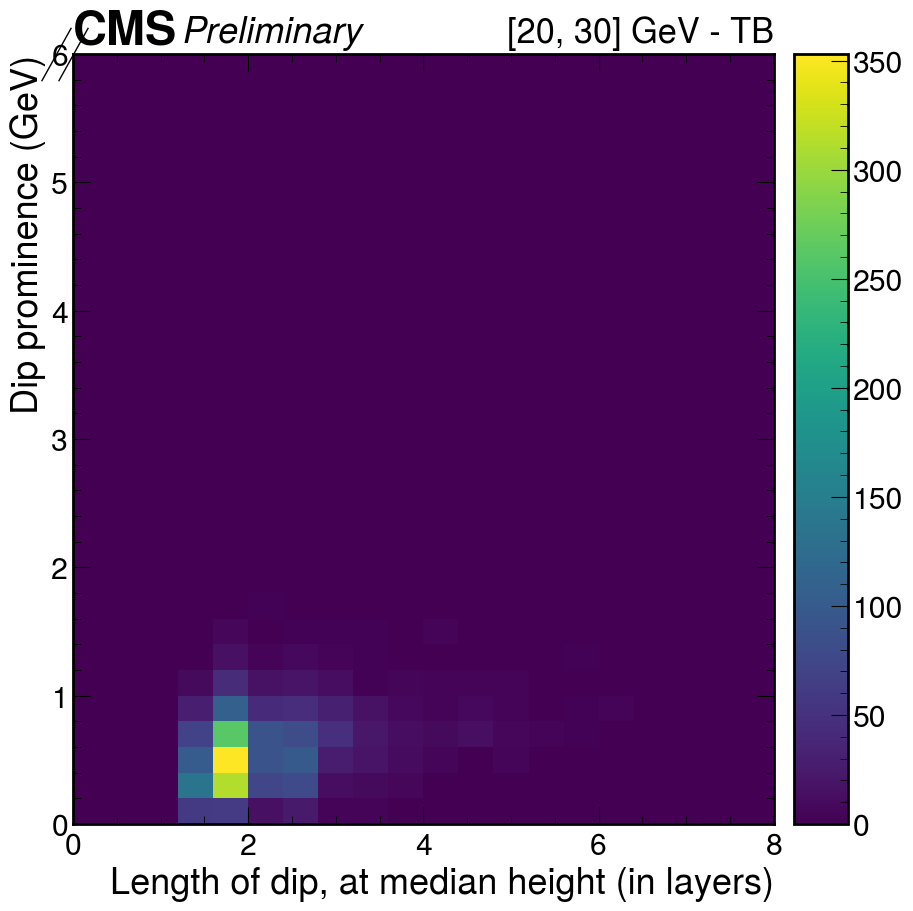

In [330]:
plotLengthProminencce(h, [20, 30])